# Code and data release for psychophysics experiment
Fig. 5 of "Recurrent connections facilitate occluded object recognition by explaining-away" (Nature Communications)

In [10]:
import os
import math
import scipy
import pickle
import seaborn
import sklearn
import scipy as sc
import numpy as np
import pandas as pd
import sklearn as sk
from scipy import stats
from tqdm import trange
from scipy import special
from seaborn import regplot
import matplotlib.pyplot as plt
from sklearn import linear_model

# Set random seed for reproducibility where applicable
np.random.seed(12759)

In [2]:
# --- Configuration ---

# Default path (can be changed)
DATA_DIRECTORY = "DataRelease"

# QC Thresholds
RT_THRESHOLD = 0.1
AC_THRESHOLD = 0.8
PERFORMANCE_THRESHOLD = 0.55

# Columns to keep
TARGET_COLUMNS = ["background_id", "foreground_id",
                  "multi_object_rotation", "occlusion_level", "single_object_id",
                  "single_is_foreground_or_random",
                  "single_object_rotation", "background_choice_id", "alt_choice_id",
                  "intra_trial_duration",
                  "alternative_is_foreground_or_random", "multi_object_exp_filename",
                  "single_object_exp_filename", "background_option_exp_filename",
                  "alternative_option_exp_filename", "participant", "date", "correct_answer",
                  "Input_selection.keys", "Was_attention_check", "Attention_check.keys",
                  "Attention_check.corr", "Input_selection.rt", "Attention_check.rt",
                  "location_of_correct_answer"]

In [3]:
# --- Helper Functions ---

def is_correct(row):
    """
    Given a trial row from a dataframe, returns boolean of whether the answer is correct or not.
    Returns: 0 (skip/no response), 1 (correct), 2 (incorrect)
    """
    try:
        if type(row["Input_selection.keys"]) != str:
            return 0

        answer = row["Input_selection.keys"][2:-2]
        corr_ans = row["correct_answer"]

        if answer == corr_ans:
            return 1
        else:
            return 2
    except:
        return 0 

def get_rt(row):
    """Extracts RT from the string format in the dataframe."""
    try:
        val = row["Input_selection.rt"]
        if isinstance(val, str):
            return float(val[1:-1])
        return float(val)
    except:
        return np.nan

In [4]:
# --- Data Loading and QC Functions ---

def load_data(directory):
    """Loads all CSV files from the specified directory."""
    if not os.path.exists(directory):
        print(f"Directory not found: {directory}")
        return [], []

    files = [f for f in os.listdir(directory) if f.endswith(".csv")]
    loaded_data = []
    loaded_files = []
    
    print(f"Found {len(files)} CSV files in {directory}")
    
    for file in files:
        filepath = os.path.join(directory, file)
        try:
            df = pd.read_csv(filepath)
            loaded_data.append(df)
            loaded_files.append(file)
        except Exception as e:
            print(f"Failed to load {file}: {e}")
            
    return loaded_data, loaded_files

def qc_attention_checks(data_list, file_list, threshold=0.8):
    """Filters subjects based on attention check performance."""
    passed_data = []
    passed_files = []
    
    for subject_data, subject_file in zip(data_list, file_list):
        try:
            was_check = subject_data["Was_attention_check"]
            check_corr = subject_data["Attention_check.corr"]
            
            num_correct = 0
            num_total = 0
            
            for check, response in zip(was_check, check_corr):
                if check and response == 1:
                    num_correct += 1
                if isinstance(check, bool) and check:
                    num_total += 1
            
            if num_total > 0 and (num_correct / num_total) > threshold:
                passed_data.append(subject_data)
                passed_files.append(subject_file)
        except Exception as e:
            print(f"Error in AC QC for {subject_file}: {e}")
            
    print(f"Subjects passing Attention Check QC: {len(passed_data)}")
    return passed_data, passed_files

def qc_response_time(data_list, file_list, threshold=0.1):
    """Filters subjects based on mean response time."""
    passed_data = []
    passed_files = []
    
    for subject_data, subject_file in zip(data_list, file_list):
        rts = []
        try:
            raw_rts = subject_data["Input_selection.rt"].tolist()
            for rt in raw_rts:
                try:
                    if isinstance(rt, str):
                        rts.append(float(rt[1:-1]))
                except:
                    pass
            
            if len(rts) > 0 and np.mean(rts) > threshold:
                passed_data.append(subject_data)
                passed_files.append(subject_file)
        except Exception as e:
            print(f"Error in RT QC for {subject_file}: {e}")

    print(f"Subjects passing RT QC: {len(passed_data)}")
    return passed_data, passed_files

def qc_performance(data_list, file_list, threshold=0.55):
    """Filters subjects based on overall task performance."""
    passed_data = []
    passed_files = []
    
    for subject_data, subject_file in zip(data_list, file_list):
        total = 0
        correct = 0
        
        for _, row in subject_data.iterrows():
            status = is_correct(row)
            if status == 1:
                correct += 1
                total += 1
            elif status == 2:
                total += 1
        
        if total > 0 and (correct / total) > threshold:
            passed_data.append(subject_data)
            passed_files.append(subject_file)
            
    print(f"Subjects passing Performance QC: {len(passed_data)}")
    return passed_data, passed_files

def pool_data(data_list, rt_threshold=0.1):
    """Pools all trials from passing subjects into a single DataFrame."""
    pooled = pd.DataFrame(columns=TARGET_COLUMNS)
    
    print("Pooling data...")
    rows_list = []
    
    for subject_data in data_list:
        for _, row in subject_data.iterrows():
            try:
                rt = get_rt(row)
                if not np.isnan(rt) and rt >= rt_threshold:
                    # Filter to target columns if they exist
                    filtered_row = {col: row[col] for col in TARGET_COLUMNS if col in row}
                    rows_list.append(filtered_row)
            except:
                pass
                
    pooled = pd.DataFrame(rows_list)
    print(f"Pooled data shape: {pooled.shape}")
    return pooled

In [5]:
# --- Execution: Load and QC Data ---

# 1. Load
raw_data, raw_files = load_data(DATA_DIRECTORY)

# 2. QC
qc1_data, qc1_files = qc_attention_checks(raw_data, raw_files, AC_THRESHOLD)
qc2_data, qc2_files = qc_response_time(qc1_data, qc1_files, RT_THRESHOLD)
final_subject_data, final_subject_files = qc_performance(qc2_data, qc2_files, PERFORMANCE_THRESHOLD)

# 3. Pool
pooled_data = pool_data(final_subject_data, RT_THRESHOLD)

Found 43 CSV files in DataRelease
Subjects passing Attention Check QC: 43
Subjects passing RT QC: 43
Subjects passing Performance QC: 43
Pooling data...
Pooled data shape: (16589, 25)


## Analysis Sections
Run the cells below to perform specific analyses.

Foreground vs Random RT: p=1.629e-08, t=-5.653


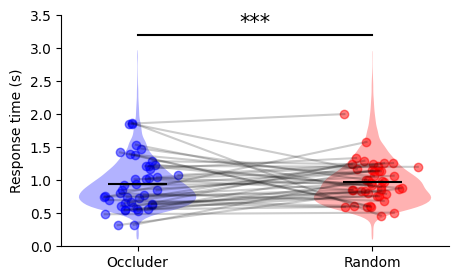

In [7]:
def analyze_condition_rt(pooled_df):
    """Analyzes RT for Fixed/Flexible and Foreground/Random conditions."""
    
    # Fixed vs Flexible
    fixed_rts = pooled_df[pooled_df["multi_object_rotation"] == "fixed"].apply(get_rt, axis=1).dropna().tolist()
    flex_rts = pooled_df[pooled_df["multi_object_rotation"] == "flexible"].apply(get_rt, axis=1).dropna().tolist()
    
    # Foreground vs Random
    fore_rts = pooled_df[pooled_df["single_is_foreground_or_random"] == "foreground"].apply(get_rt, axis=1).dropna().tolist()
    rand_rts = pooled_df[pooled_df["single_is_foreground_or_random"] == "random"].apply(get_rt, axis=1).dropna().tolist()
    
    # Plot: Foreground vs Random (Violin plot with individual points)
    data1 = fore_rts
    data2 = rand_rts
    
    fig = plt.figure(figsize=(5, 3))
    violins = plt.violinplot([data1, data2], showextrema=False, showmeans=True)

    colors = ["blue", "red"]
    for i, body in enumerate(violins['bodies']):
        body.set_facecolor(colors[i])
    violins['cmeans'].set_edgecolor('black')

    # Plot individual points
    # Get random trial from each condition for each subject to connect points
    subjects = pooled_df["participant"].unique()
    subj_rts = {s: [] for s in subjects}
    
    # Helper to get one RT per subject per condition
    def get_subj_rt(cond_val):
        for s in subjects:
            trials = pooled_df[(pooled_df["participant"] == s) & (pooled_df["single_is_foreground_or_random"] == cond_val)]
            if not trials.empty:
                # Pick random trial
                trial = trials.sample(1).iloc[0]
                rt = get_rt(trial)
                if not np.isnan(rt):
                    subj_rts[s].append(rt)
                else:
                    subj_rts[s].append(np.nan)
            else:
                subj_rts[s].append(np.nan)
    
    for s in subjects:
        fore_trials = pooled_df[(pooled_df["participant"] == s) & (pooled_df["single_is_foreground_or_random"] == "foreground")]
        rand_trials = pooled_df[(pooled_df["participant"] == s) & (pooled_df["single_is_foreground_or_random"] == "random")]
        
        if not fore_trials.empty and not rand_trials.empty:
            try:
                rt1 = get_rt(fore_trials.sample(1).iloc[0])
                rt2 = get_rt(rand_trials.sample(1).iloc[0])
                
                if not np.isnan(rt1) and not np.isnan(rt2):
                    jit1 = np.random.normal(0, 0.07)
                    jit2 = np.random.normal(0, 0.07)
                    
                    plt.plot([1 + jit1, 2 + jit2], [rt1, rt2], color="black", alpha=0.2)
                    plt.scatter(1 + jit1, rt1, color="blue", alpha=0.5)
                    plt.scatter(2 + jit2, rt2, color="red", alpha=0.5)
            except:
                pass

    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.xticks([1, 2], labels=["Occluder", "Random"])
    plt.ylim(0, 3.5)
    plt.ylabel("Response time (s)")
    
    # Stats
    min_len = min(len(data1), len(data2))
    res = sc.stats.ttest_rel(data1[:min_len], data2[:min_len])
    pval = res.pvalue
    print(f"Foreground vs Random RT: p={pval:.3e}, t={res.statistic:.3f}")
    
    # Significance bars
    if pval < 0.05:
        plt.plot([1, 2], [3.2, 3.2], color="black")
        stars = "*" if pval > 0.01 else "**" if pval > 0.001 else "***"
        plt.annotate(stars, (1.5, 3.3), fontsize=15, ha='center')
        
    plt.show()

# Run Analysis
analyze_condition_rt(pooled_data)

Foreground vs Random Perf: p=1.938e-05, t=4.815


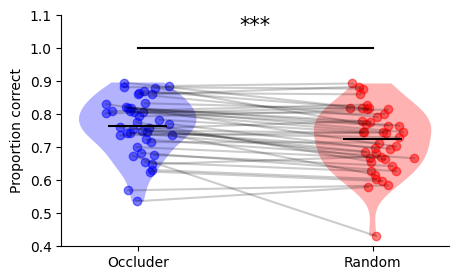

In [8]:
def analyze_condition_performance(pooled_df):
    """Analyzes Performance for Fixed/Flexible and Foreground/Random conditions."""
    
    # Helper to get per-subject means
    def get_means(condition_col, val1, val2):
        means1, means2 = {}, {}
        subjects = pooled_df["participant"].unique()
        
        for sub in subjects:
            sub_data = pooled_df[pooled_df["participant"] == sub]
            
            # Cond 1
            c1_data = sub_data[sub_data[condition_col] == val1]
            corr1 = [1 if is_correct(r) == 1 else 0 for _, r in c1_data.iterrows() if is_correct(r) != 0]
            if corr1: means1[sub] = np.mean(corr1)
            
            # Cond 2
            c2_data = sub_data[sub_data[condition_col] == val2]
            corr2 = [1 if is_correct(r) == 1 else 0 for _, r in c2_data.iterrows() if is_correct(r) != 0]
            if corr2: means2[sub] = np.mean(corr2)
            
        # Align subjects
        common_subs = set(means1.keys()) & set(means2.keys())
        return [means1[s] for s in common_subs], [means2[s] for s in common_subs]

    fixed_means, flex_means = get_means("multi_object_rotation", "fixed", "flexible")
    fore_means, rand_means = get_means("single_is_foreground_or_random", "foreground", "random")
    
    # Plot: Foreground vs Random (Violin plot)
    data1 = fore_means
    data2 = rand_means
    
    fig = plt.figure(figsize=(5, 3))
    violins = plt.violinplot([data1, data2], showextrema=False, showmeans=True)

    colors = ["blue", "red"]
    for i, body in enumerate(violins['bodies']):
        body.set_facecolor(colors[i])
    violins['cmeans'].set_edgecolor('black')
    
    # Plot individual points
    for p1, p2 in zip(data1, data2):
        jit1 = np.random.normal(0, 0.07)
        jit2 = np.random.normal(0, 0.07)
        
        plt.plot([1 + jit1, 2 + jit2], [p1, p2], color="black", alpha=0.2)
        plt.scatter(1 + jit1, p1, color="blue", alpha=0.5)
        plt.scatter(2 + jit2, p2, color="red", alpha=0.5)
        
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.xticks([1, 2], labels=["Occluder", "Random"])
    plt.ylim(0.4, 1.1)
    plt.ylabel("Proportion correct")
    
    # Stats
    res = sc.stats.ttest_rel(data1, data2)
    pval = res.pvalue
    print(f"Foreground vs Random Perf: p={pval:.3e}, t={res.statistic:.3f}")
    
    if pval < 0.05:
        plt.plot([1, 2], [1., 1.], color="black")
        stars = "*" if pval > 0.01 else "**" if pval > 0.001 else "***"
        plt.annotate(stars, (1.5, 1.05), fontsize=15, ha='center')
        
    plt.show()

# Run Analysis
analyze_condition_performance(pooled_data)

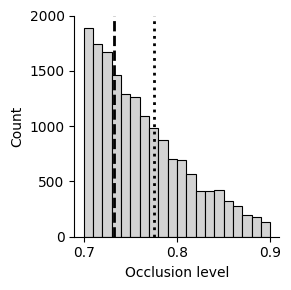

Low p: 0.0010896950740438536
Medium p: 0.0031241754844318673
High p: 0.010225870608262803


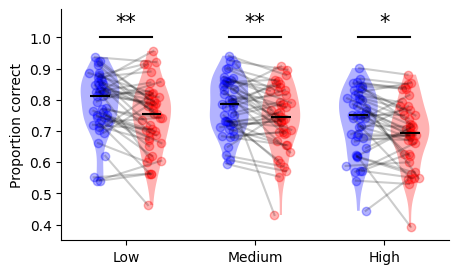

In [9]:
def analyze_occlusion_bins(pooled_df):
    """Analyzes RT and Performance across occlusion bins."""
    
    # --- 1. Histogram of Occlusion Levels ---
    fig = plt.figure(figsize=(3, 3))

    plt.hist(pooled_df["occlusion_level"], bins=20, color="lightgray", edgecolor="black", linewidth=0.8)
    plt.xlabel("Occlusion level")
    plt.ylabel("Count")
    # plt.title("Occlusion level histogram w/ bin divisions")

    thresh_1, thresh_2 = np.percentile(a=pooled_df["occlusion_level"], q=[34, 66])

    plt.axvline(x=thresh_1, label="First third", c="k", linestyle="--", linewidth=2)
    plt.axvline(x=thresh_2, label="Second third", c="k", linestyle=":", linewidth=2)
    # plt.legend(frameon=False)

    plt.xticks([0.7, 0.8, 0.9])
    plt.yticks([0, 500, 1000, 1500, 2000])

    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.tight_layout()
    plt.show()
    # plt.savefig(fname="occlusion_bins.pdf", dpi=300)

    # --- Data Preparation for Performance Plot ---
    # Split trials into bins.
    bin1_trials = pooled_df[pooled_df["occlusion_level"] < thresh_1]
    bin2_trials = pooled_df[(pooled_df["occlusion_level"] >= thresh_1) & (pooled_df["occlusion_level"] < thresh_2)]
    bin3_trials = pooled_df[pooled_df["occlusion_level"] >= thresh_2]
    
    bins = [bin1_trials, bin2_trials, bin3_trials]
    
    # Calculate performance per subject per bin per condition
    foreground_bins_perf = []
    random_bins_perf = []
    
    subjects = pooled_df["participant"].unique()
    
    for bin_df in bins:
        bin_fore_perf = []
        bin_rand_perf = []
        
        for sub in subjects:
            sub_data = bin_df[bin_df["participant"] == sub]
            
            # Foreground
            fore_data = sub_data[sub_data["single_is_foreground_or_random"] == "foreground"]
            fore_corr = [1 if is_correct(r) == 1 else 0 for _, r in fore_data.iterrows() if is_correct(r) != 0]
            
            # Random
            rand_data = sub_data[sub_data["single_is_foreground_or_random"] == "random"]
            rand_corr = [1 if is_correct(r) == 1 else 0 for _, r in rand_data.iterrows() if is_correct(r) != 0]
            
            # Only include if subject has data for both in this bin (to match paired t-test logic)
            if fore_corr and rand_corr:
                bin_fore_perf.append(np.mean(fore_corr))
                bin_rand_perf.append(np.mean(rand_corr))
                
        foreground_bins_perf.append(bin_fore_perf)
        random_bins_perf.append(bin_rand_perf)
    
    # --- 2. Violin Plot for Performance ---
    fig = plt.figure(figsize=(5, 3))

    data_a = list(foreground_bins_perf)
    data_b = list(random_bins_perf)

    ticks = ["Low", "Medium", "High"]

    def set_violin_color(vp, color):
        for patch in vp['bodies']:
            patch.set_facecolor(color)
        vp['cmedians'].set_edgecolor("black")

    vpl = plt.violinplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.4, widths=0.6, showmedians=True, showextrema=False)
    vpr = plt.violinplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.4, widths=0.6, showmedians=True, showextrema=False)
    set_violin_color(vpl, "blue")
    set_violin_color(vpr, "red")

    # Draw temporary red and blue lines and use them to create a legend.
    plt.plot([], c="red", label="Random")
    plt.plot([], c="blue", label="Occluder")
    # plt.legend(frameon=False, loc="upper right")

    plt.xticks(range(0, len(ticks) * 2, 2), ticks, rotation=0)
    plt.ylim(0.35, 1.09)
    plt.xlim(-1, 5)

    plt.ylabel("Proportion correct")

    # Plot individual data points and lines connecting points from same subjects.
    pos_a = np.array(range(len(data_a)))*2.0-0.4
    pos_b = np.array(range(len(data_b)))*2.0+0.4
    for j, (dist_a, dist_b) in enumerate(zip(data_a, data_b)):
        for i in range(len(dist_a)):
            if i < len(dist_b) and i < len(dist_a):
                foreground_jitter = np.random.normal(loc=0, scale=0.07)
                random_jitter = np.random.normal(loc=0, scale=0.07)

                plt.plot([pos_a[j] + foreground_jitter, pos_b[j] + random_jitter], [dist_a[i], dist_b[i]], color="black", alpha=0.2)

                plt.scatter(pos_a[j] + foreground_jitter, dist_a[i], color="blue", alpha=0.3)
                plt.scatter(pos_b[j] + random_jitter, dist_b[i], color="red", alpha=0.3)

    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Statistical tests--since vectors need equal lengths, limiting the longer one.
    # Note: My data prep ensures they are paired (same length), but keeping the safety check.
    bin1_foreground_perf_dist = data_a[0]
    bin1_random_perf_dist = data_b[0]
    bin2_foreground_perf_dist = data_a[1]
    bin2_random_perf_dist = data_b[1]
    bin3_foreground_perf_dist = data_a[2]
    bin3_random_perf_dist = data_b[2]

    bin1_res = sc.stats.ttest_rel(bin1_foreground_perf_dist, bin1_random_perf_dist[:len(bin1_foreground_perf_dist)])
    bin2_res = sc.stats.ttest_rel(bin2_random_perf_dist, bin2_foreground_perf_dist[:len(bin2_random_perf_dist)])
    bin3_res = sc.stats.ttest_rel(bin3_random_perf_dist, bin3_foreground_perf_dist[:len(bin3_random_perf_dist)])

    low_p = bin1_res.pvalue
    medium_p = bin2_res.pvalue
    high_p = bin3_res.pvalue
    
    print(f"Low p: {low_p}")
    print(f"Medium p: {medium_p}")
    print(f"High p: {high_p}")

    # Draw plot on top of each pair of violin plots.
    plt.plot([pos_a[0], pos_b[0]], [1., 1.], color="black")
    plt.plot([pos_a[1], pos_b[1]], [1., 1.], color="black")
    plt.plot([pos_a[2], pos_b[2]], [1., 1.], color="black")

    # Add stars.
    def get_stars(p):
        if p < 0.001: return "***"
        elif p < 0.01: return "**"
        elif p < 0.05: return "*"
        else: return "n.s."

    plt.annotate(get_stars(low_p), ((pos_a[0] + pos_b[0]) * .5, 1.03), fontsize=15, ha="center")
    plt.annotate(get_stars(medium_p), ((pos_a[1] + pos_b[1]) * .5, 1.03), fontsize=15, ha="center")
    plt.annotate(get_stars(high_p), ((pos_a[2] + pos_b[2]) * .5, 1.03), fontsize=15, ha="center")

    # plt.legend(frameon=False, loc="upper right", markerfirst=True)

    # plt.savefig(fname="occl_bin_performance.pdf", dpi=300)
    plt.show()

# Run Analysis
analyze_occlusion_bins(pooled_data)